In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import OneHotEncoder

# Load & Preprocess Data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
label_dict = {
  0: 'T-shirt/top',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle boot'
}

## Normalise Image Data

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## One-Hot Encode Labels

In [5]:
ohe = OneHotEncoder(categories='auto')
ohe.fit(y_train.reshape(-1, 1))
y_train = ohe.transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

# Basic Exploratory Data Analysis

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
print('train data shape: {}; target shape: {}'.format(X_train.shape, y_train.shape))
print('test data shape: {}; target shape: {}'.format(X_test.shape, y_test.shape))

train data shape: (60000, 28, 28); target shape: (60000, 10)
test data shape: (10000, 28, 28); target shape: (10000, 10)


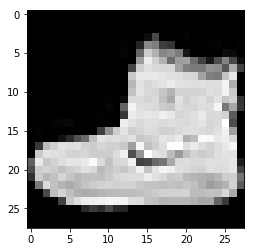

In [8]:
sample = X_train[0]
plt.imshow(sample, cmap='gray')

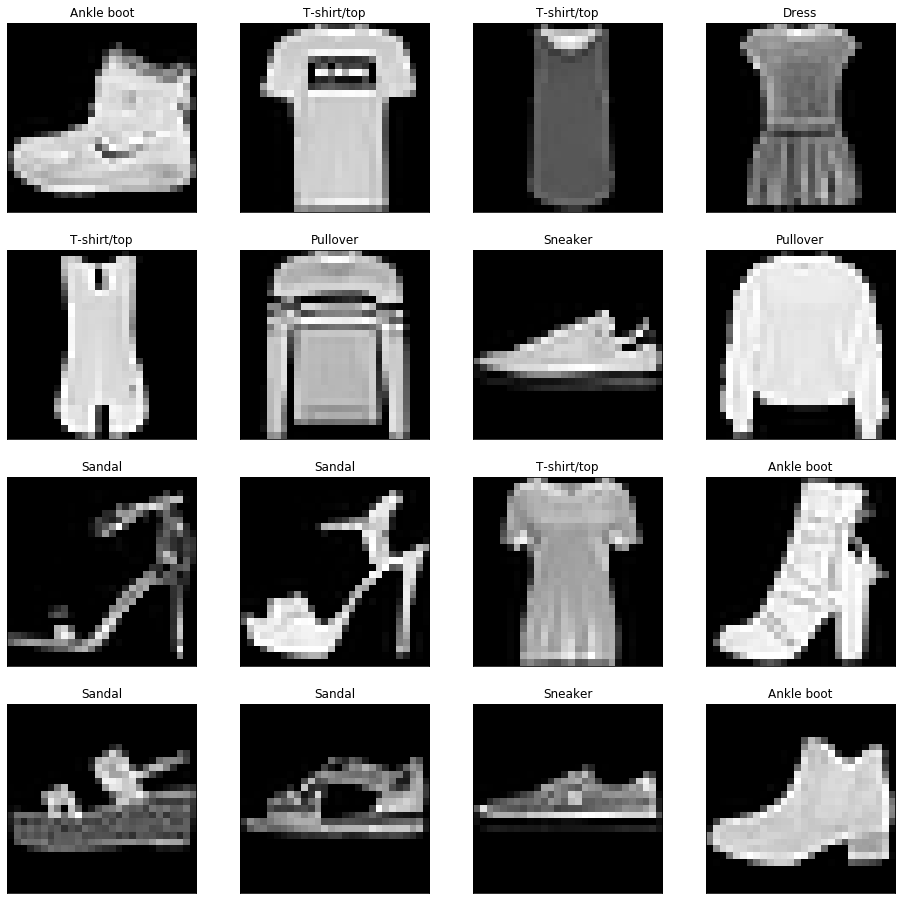

In [9]:
nrows = 4
ncols = 4

fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(16, 16)

i = 0

for row in range(nrows):
    for col in range(ncols):
        img = X_train[i]
        label = label_dict[y_train[i].argmax()]

        axis = axes[row, col]
        axis.imshow(img, cmap='gray')
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        axis.set_title(label)
        
        i += 1

# Building the Model

In [10]:
batch_size = 32
img_dim = X_train[0].shape

print('Image Dimensions: {}'.format(img_dim))

Image Dimensions: (28, 28)


In [11]:
model = keras.models.Sequential([
    Flatten(input_shape=img_dim),
    Dense(512),
    Activation('relu'),
    Dense(10),
    Activation('softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training and Evaluating the Model

In [12]:
%%time 

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=batch_size,
          epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.4921 - acc: 0.8241 - val_loss: 0.4361 - val_acc: 0.8478
Epoch 2/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.3806 - acc: 0.8654 - val_loss: 0.4778 - val_acc: 0.8455
Epoch 3/10
60000/60000 [==============================] - 4s 73us/step - loss: 0.3549 - acc: 0.8793 - val_loss: 0.4262 - val_acc: 0.8604
Epoch 4/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.3414 - acc: 0.8852 - val_loss: 0.4344 - val_acc: 0.8628
Epoch 5/10
60000/60000 [==============================] - 4s 73us/step - loss: 0.3320 - acc: 0.8888 - val_loss: 0.4193 - val_acc: 0.8749
Epoch 6/10
60000/60000 [==============================] - 4s 73us/step - loss: 0.3231 - acc: 0.8937 - val_loss: 0.4112 - val_acc: 0.8723
Epoch 7/10
60000/60000 [==============================] - 4s 73us/step - loss: 0.3171 - acc: 0.8979 - val_loss: 0.4336 - val_acc

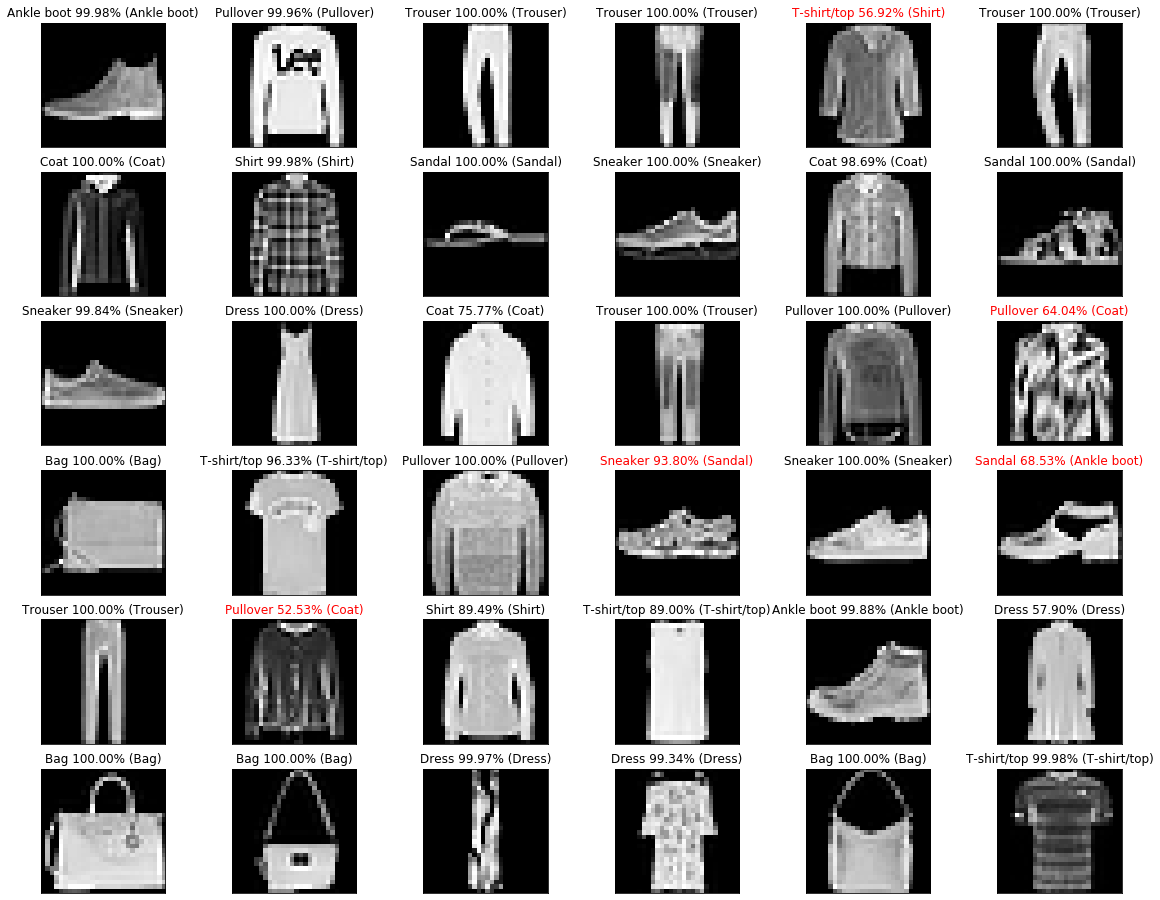

In [14]:
nrows = 6
ncols = 6
ntotal = nrows * ncols
i = 0

fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(20, 16)

predictions = model.predict_proba(X_test[:ntotal])

for row in range(nrows):
    for col in range(ncols):
        img = X_test[i]        
        predicted_label = label_dict[predictions[i].argmax()]
        probability = predictions[i].max() * 100
        actual_label = label_dict[y_test[i].argmax()]
        title_colour = 'black' if predicted_label == actual_label else 'red'

        axis = axes[row, col]
        axis.imshow(img, cmap='gray')
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        axis.set_title('{} {:.2f}% ({})'.format(predicted_label, probability, actual_label), color=title_colour)
        
        i += 1

# CNN

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
import numpy as np

## Expand Data Dimensions

Add in an extra dimension for channels.
The images in the Fashion MNIST dataset are grayscale so there is only one channel.

In [16]:
print(img_dim)
print(X_train.shape)
print(X_test.shape)

(28, 28)
(60000, 28, 28)
(10000, 28, 28)


In [17]:
X_train_with_channels = np.expand_dims(X_train, axis=3)
X_test_with_channels = np.expand_dims(X_test, axis=3)
cnn_input_shape = X_train_with_channels[0].shape

print(img_dim)
print(X_train_with_channels.shape)
print(X_test_with_channels.shape)

(28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


## CNN Model

In [18]:
cnn = keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=cnn_input_shape),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(10, activation='softmax')
])

In [19]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [20]:
cnn.compile(optimizer='rmsprop',
           loss=keras.losses.categorical_crossentropy,
           metrics=['accuracy'])

## Train & Evaluate Model

In [21]:
%%time 
history = cnn.fit(X_train_with_channels, y_train, 
                  validation_data=(X_test_with_channels, y_test), 
                  batch_size=batch_size, 
                  epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 158us/step - loss: 0.4777 - acc: 0.8277 - val_loss: 0.3348 - val_acc: 0.8849
Epoch 2/10
60000/60000 [==============================] - 8s 141us/step - loss: 0.3448 - acc: 0.8785 - val_loss: 0.3551 - val_acc: 0.8819
Epoch 3/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.3336 - acc: 0.8842 - val_loss: 0.3411 - val_acc: 0.8910
Epoch 4/10
60000/60000 [==============================] - 9s 145us/step - loss: 0.3356 - acc: 0.8846 - val_loss: 0.3219 - val_acc: 0.8918
Epoch 5/10
60000/60000 [==============================] - 9s 144us/step - loss: 0.3356 - acc: 0.8849 - val_loss: 0.3765 - val_acc: 0.8885
Epoch 6/10
60000/60000 [==============================] - 8s 142us/step - loss: 0.3443 - acc: 0.8826 - val_loss: 0.3328 - val_acc: 0.8887
Epoch 7/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.3443 - acc: 0.8827 - val_loss: 0.3127 -

Text(0.5, 1.0, 'CNN Accuracy')

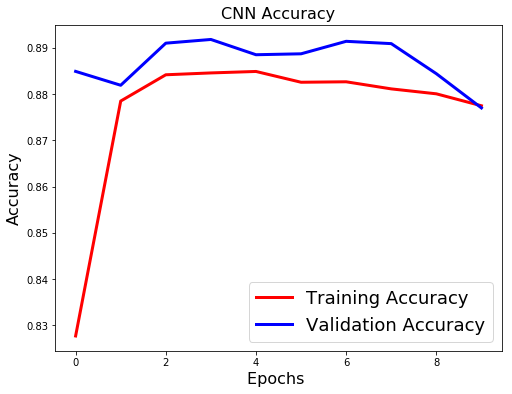

In [22]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('CNN Accuracy',fontsize=16)

In [23]:
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         figsize=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    
    if figsize is not None:
        plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.84      0.82      0.83      1000
           3       0.88      0.88      0.88      1000
           4       0.69      0.92      0.79      1000
           5       0.99      0.91      0.95      1000
           6       0.80      0.49      0.60      1000
           7       0.90      0.98      0.94      1000
           8       0.96      0.98      0.97      1000
           9       0.96      0.95      0.95      1000

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



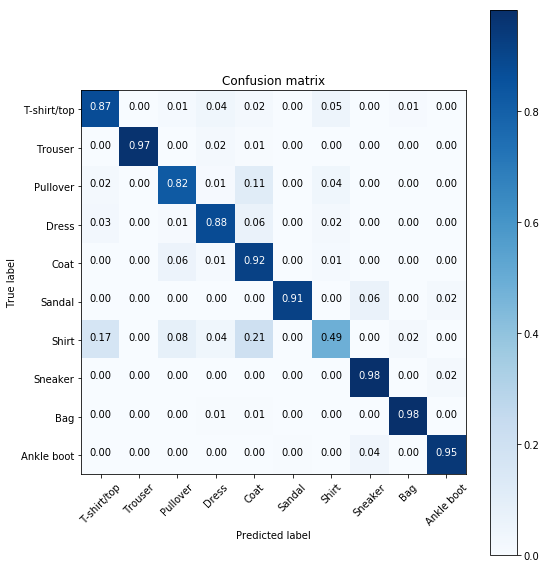

In [24]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report

predictions = cnn.predict(X_test_with_channels)
predictions = predictions.argmax(axis=1)
ground_truth = y_test.argmax(axis=1)

# print(confusion_matrix(ground_truth, predictions)))
# print()
plot_confusion_matrix(confusion_matrix(ground_truth, predictions), list(label_dict.values()), normalize=True, figsize=(8, 8))

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

print(classification_report(ground_truth, predictions))

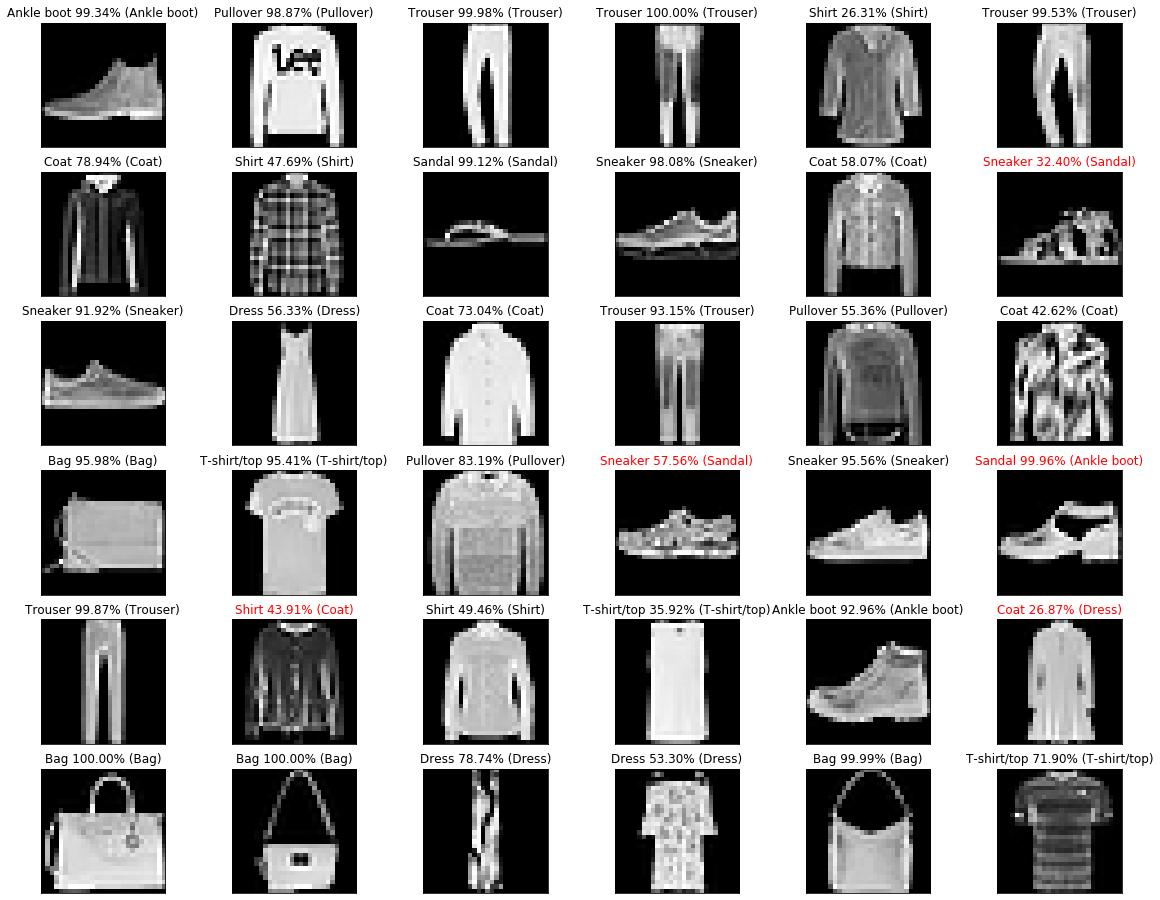

In [25]:
nrows = 6
ncols = 6
ntotal = nrows * ncols
i = 0

fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(20, 16)

predictions = cnn.predict_proba(X_test_with_channels[:ntotal])

for row in range(nrows):
    for col in range(ncols):
        img = X_test[i]        
        predicted_label = label_dict[predictions[i].argmax()]
        probability = predictions[i].max() * 100
        actual_label = label_dict[y_test[i].argmax()]
        title_colour = 'black' if predicted_label == actual_label else 'red'

        axis = axes[row, col]
        axis.imshow(img, cmap='gray')
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        axis.set_title('{} {:.2f}% ({})'.format(predicted_label, probability, actual_label), color=title_colour)
        
        i += 1